In [60]:
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [61]:
df_answers_1 = pl.read_csv("../answers/answers_1.csv")
df_answers_2 = pl.read_csv("../answers/answers_2.csv")


df_indiviudal_1 = pl.read_csv("../individuals/individuals_1.csv")
df_indiviudal_2 = pl.read_csv("../individuals/individuals_2.csv")


df_properties = pl.read_csv("../statementproperties/statementproperties_1.csv")

df_statements = pl.read_csv("../statements/statements_1.csv")

# 1. Concatenate the two DataFrames vertically
df_answers = pl.concat([df_answers_1, df_answers_2], how="vertical")

# 2. Concatenate the two DataFrames vertically
df_indiviudal = pl.concat([df_indiviudal_1, df_indiviudal_2], how="vertical")


df_answers.group_by("sessionId")



In [62]:
df_answers.group_by("sessionId").agg(pl.count("sessionId").alias("count")).filter(
    pl.col("count") >= 15
)

sessionId,count
str,u32
"""tuor_Xc5Rqu2Z5Bq2Xd6CoJdfu9xe2…",15
"""xcvZAT1StYAmJM92D_QNxHkLxBqxLV…",15
"""-ThXR_rVqZz3N-5xXTX8z_vRXsSZ3Q…",15
"""gnxynTJ2uFEVYr_hL_DWVDHBjeoExG…",15
"""l60o5_03dWD4VZZdMs5PQUX5hCLLwS…",30
…,…
"""7AE-oT0YLwpo4n0JHnGSeeUSpptsh3…",15
"""MAWsRC_gJ81LhLrqFist3QaUktrz0Y…",15
"""31HmRW35mYWmBNLCx3brCQNcXN8iZ-…",15


In [63]:
df_answers = df_answers.with_columns(
    [pl.col("I_agree").cast(pl.Float64), pl.col("others_agree").cast(pl.Float64)]
)

df_answers.head(4)

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null
4,1.0,"""It's obvious""",1.0,"""I think most people lack good …",0,"""Clear: it is clearly written a…","""en""","""n4yeiqY8p1DDUmxhKphavobA-w5LCn…","""2023-06-14 17:11:27""","""2023-06-14 17:11:27""",149,149,null


In [64]:
df_median = df_answers.group_by("statementId").agg(
    pl.col("I_agree").median().alias("median_I_agree")
)

df_joined = df_answers.join(df_median, on="statementId", how="left")

df_joined = df_joined.with_columns(
    [
        (pl.col("I_agree") == pl.col("median_I_agree"))
        .cast(pl.Float64)
        .alias("is_consensus"),
        pl.when(pl.col("median_I_agree") == 0.5)
        .then(1.0)
        .otherwise(
            (pl.col("others_agree") == pl.col("median_I_agree")).cast(pl.Float64)
        )
        .alias("is_aware"),
    ]
)

df_joined.head(4)

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str,f64,f64,f64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0
4,1.0,"""It's obvious""",1.0,"""I think most people lack good …",0,"""Clear: it is clearly written a…","""en""","""n4yeiqY8p1DDUmxhKphavobA-w5LCn…","""2023-06-14 17:11:27""","""2023-06-14 17:11:27""",149,149,null,1.0,1.0,1.0


In [65]:
df_joined.shape

(790771, 17)

In [66]:
df_session = (
    df_joined.group_by("sessionId")
    .agg(
        [
            pl.col("is_consensus").mean().alias("consensus"),
            pl.col("is_aware").mean().alias("awareness"),
            pl.len().alias("response_count"),
        ]
    )
    .filter(pl.col("response_count") > 10)
    .with_columns(
        (pl.col("awareness") * pl.col("consensus")).sqrt().alias("commonsensicality")
    )
)

df_session = df_session.with_columns(
    ((pl.col("awareness") * pl.col("consensus")).sqrt()).alias("commonsensicality")
)

df_session

sessionId,consensus,awareness,response_count,commonsensicality
str,f64,f64,u32,f64
"""F7Zoz5KFjHiPmiCXOVX1NteRzJPcPZ…",0.666667,0.6,15,0.632456
"""tY8xpv1z4WzYKeiM9ylukCQLaGpRVv…",1.0,0.866667,15,0.930949
"""_UWETwjyiiriCWF0t4Hq_-YuAZVfQy…",0.733333,0.4,15,0.541603
"""oTetKqkh32jm8ZYIbMdTA0Az_eIS45…",0.733333,0.8,15,0.765942
"""gqDHwDyhhSWXqiYH3XWbt_wWihYAaM…",0.933333,0.866667,15,0.899383
…,…,…,…,…
"""ttvprCiwq8VvNtAcyYIiq0WYNL2VYG…",0.583333,0.833333,12,0.697217
"""TUUJtyLRK4rhUL7XLQZb4ccgAcuiol…",0.857143,0.785714,14,0.820652
"""mjVN2x6VVG7nyVylPyKNBMHUmkNz_4…",0.8,0.8,15,0.8


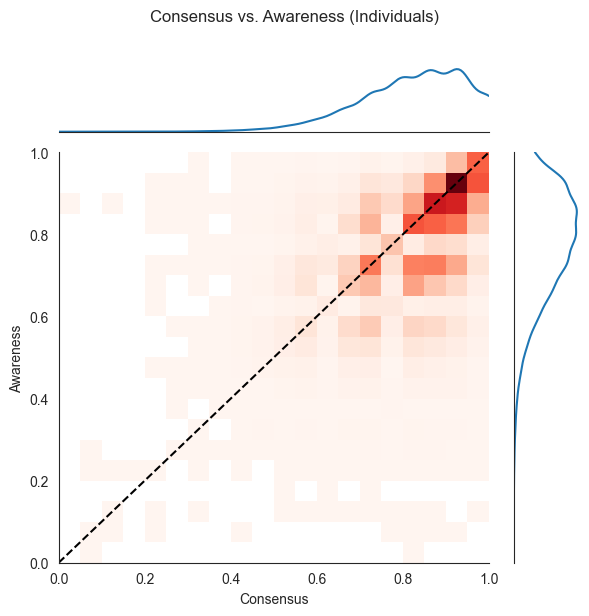

In [67]:
# json.loads(df_indiviudal[100].select("experimentInfo").to_numpy()[0][0])

df_pandas = df_session.to_pandas()

sns.set_style("white")

# Create an empty JointGrid
g = sns.JointGrid(data=df_pandas, x="consensus", y="awareness")

# Plot the 2D histogram in the center
g.plot_joint(sns.histplot, bins=20, cmap="Reds")

# Plot the marginals as line-based KDE curves
g.plot_marginals(
    sns.kdeplot,
    fill=False,        # no fill, just the line
    bw_adjust=2,     # increase bandwidth to smooth
    cut=0,             # don't extend the curve beyond the data
    clip=(0, 1)        # limit KDE to [0,1] (assuming consensus/awareness in [0,1])
)

# Add the reference diagonal
g.ax_joint.plot([0, 1], [0, 1], ls="--", color="black")

# Adjust axes and labels
g.ax_joint.set_xlim(0, 1)
g.ax_joint.set_ylim(0, 1)
g.set_axis_labels("Consensus", "Awareness")

# Title and layout
plt.suptitle("Consensus vs. Awareness (Individuals)", y=1.02)
plt.tight_layout()
plt.savefig("consensus_vs_awareness_individuals.pdf", dpi=300, bbox_inches="tight")

In [68]:
df_properties

id,name,available,createdAt,updatedAt,statementId
i64,str,i64,str,str,i64
1,"""behavior""",0,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
2,"""everyday""",1,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
3,"""figure_of_speech""",0,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
4,"""judgment""",0,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
5,"""opinion""",0,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
…,…,…,…,…,…
60656,"""everyday""",1,"""2025-02-18 14:49:40""","""2025-02-18 14:49:40""",8859
60657,"""figure_of_speech""",0,"""2025-02-18 14:49:40""","""2025-02-18 14:49:40""",8859
60658,"""judgment""",1,"""2025-02-18 14:49:40""","""2025-02-18 14:49:40""",8859


In [69]:
properties_wide = df_properties.pivot(
    index="statementId",
    columns="name",
    values="available",
)

properties_wide

/var/folders/5j/9pnb21r14qjbflhqq7gq72lr0000gn/T/ipykernel_66458/1597815251.py:1: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  properties_wide = df_properties.pivot(


statementId,behavior,everyday,figure_of_speech,judgment,opinion,reasoning
i64,i64,i64,i64,i64,i64,i64
1,0,1,0,0,0,1
2,0,0,0,0,0,0
3,1,1,0,1,0,1
4,0,1,0,0,0,0
5,0,1,0,1,1,0
…,…,…,…,…,…,…
8855,1,1,0,1,1,1
8856,1,1,0,1,1,1
8857,1,1,0,1,1,1


In [70]:
joined_answer_df = df_joined.join(
    properties_wide, 
    on="statementId",   
    how="inner"         
)

joined_answer_df.head(4)

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware,behavior,everyday,figure_of_speech,judgment,opinion,reasoning
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str,f64,f64,f64,i64,i64,i64,i64,i64,i64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
4,1.0,"""It's obvious""",1.0,"""I think most people lack good …",0,"""Clear: it is clearly written a…","""en""","""n4yeiqY8p1DDUmxhKphavobA-w5LCn…","""2023-06-14 17:11:27""","""2023-06-14 17:11:27""",149,149,null,1.0,1.0,1.0,0,0,1,1,0,1


In [71]:
medians_means = (
    joined_answer_df
    .group_by("statementId")
    .agg([
        pl.col("I_agree").median().alias("median_i_agree"),
        pl.col("I_agree").mean().alias("mean_i_agree"),
    ])
)

medians_means.head(3)

statementId,median_i_agree,mean_i_agree
i64,f64,f64
292,0.0,0.467213
4201,1.0,0.650485
9831,1.0,0.936508


In [72]:
answers_with_medians = joined_answer_df.join(medians_means, on="statementId")
answers_with_medians.head(3)

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,median_i_agree,mean_i_agree
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517


In [73]:
answers_with_awareness = answers_with_medians.with_columns(
    pl.when(pl.col("median_i_agree") == 0.5)
    .then(pl.lit(1.0))
    .otherwise((pl.col("others_agree") == pl.col("median_i_agree")).cast(pl.Float64()))
    .alias("awareness_row")
)

In [74]:
answers_with_awareness.head(3)

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,median_i_agree,mean_i_agree,awareness_row
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517,1.0
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517,1.0
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517,1.0


In [75]:
statement_commonsense = (
    answers_with_awareness.group_by("statementId")
    .agg(
        [
            pl.col("awareness_row").mean().alias("statement_awareness"),
            pl.col("mean_i_agree").mean().alias("mean_of_mean_i_agree"),
        ]
    )
    .with_columns(
        [(2 * (pl.col("mean_of_mean_i_agree") - 0.5).abs()).alias("statement_consensus")]
    )
    .with_columns(
        [
            (pl.col("statement_awareness") * pl.col("statement_consensus"))
            .sqrt()
            .alias("actual_commonsensicality")
        ]
    )
    .select(["statementId", "statement_awareness", "statement_consensus", "actual_commonsensicality"])
)

In [76]:
statement_commonsensicality_with_properties = statement_commonsense.join(properties_wide, on="statementId", how="left")

# statement_commonsensicality_with_properties

In [77]:
long_df = statement_commonsensicality_with_properties.melt(
    id_vars=["statementId", "actual_commonsensicality"],
    value_vars=[
        "behavior",
        "everyday",
        "figure_of_speech",
        "judgment",
        "opinion",
        "reasoning",
    ],
    variable_name="property_name",
    value_name="has_property",
)

# long_df

/var/folders/5j/9pnb21r14qjbflhqq7gq72lr0000gn/T/ipykernel_66458/1008483862.py:1: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  long_df = statement_commonsensicality_with_properties.melt(


In [78]:
import numpy as np

boot_res = []

n_boot = 500
prop_list = [
    "behavior",
    "everyday",
    "figure_of_speech",
    "judgment",
    "opinion",
    "reasoning",
]

for prop in prop_list:

    true_vals = long_df.filter(
        (pl.col("property_name") == prop) & (pl.col("has_property") == 1)
    )["actual_commonsensicality"].to_numpy()
    false_vals = long_df.filter(
        (pl.col("property_name") == prop) & (pl.col("has_property") == 0)
    )["actual_commonsensicality"].to_numpy()

    nT = len(true_vals)
    nF = len(false_vals)
    for _ in range(n_boot):
        sample_T = np.random.choice(true_vals, size=nT, replace=True)
        sample_F = np.random.choice(false_vals, size=nF, replace=True)
        mean_diff = sample_T.mean() - sample_F.mean()
        boot_res.append((prop, mean_diff))


boot_df = pl.DataFrame(boot_res, schema=["property_name", "difference_mean"])

/var/folders/5j/9pnb21r14qjbflhqq7gq72lr0000gn/T/ipykernel_66458/3102902135.py:33: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  boot_df = pl.DataFrame(boot_res, schema=["property_name", "difference_mean"])


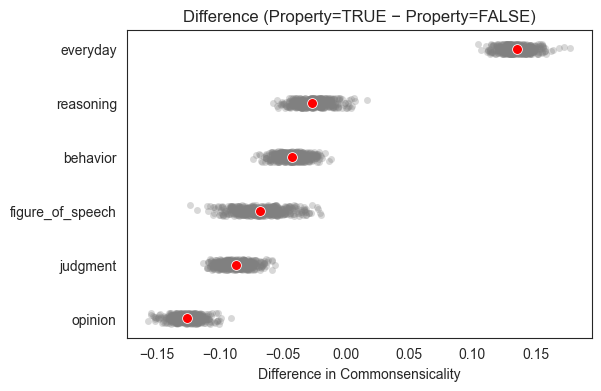

In [79]:
mean_diffs = (
    boot_df.group_by("property_name")
    .agg(pl.col("difference_mean").mean().alias("mean_diff"))
    .sort("mean_diff", descending=True)
)

mean_df_pd = mean_diffs.to_pandas()

cat_order = mean_df_pd["property_name"].tolist()


plt.figure(figsize=(6, 4))


sns.stripplot(
    data=boot_df.to_pandas(),
    x="difference_mean",
    y="property_name",
    alpha=0.3,
    color="gray",
    order=cat_order,
)

sns.scatterplot(
    data=mean_df_pd,
    x="mean_diff",
    y="property_name",
    color="red",
    s=50,
    zorder=10,
    hue_order=cat_order,
)


plt.xlabel("Difference in Commonsensicality")
plt.ylabel("")
plt.title("Difference (Property=TRUE − Property=FALSE)")
plt.show()

In [80]:
category_plot_df = statement_commonsensicality_with_properties.join(
    df_statements, left_on="statementId", right_on="id", how="left"
)

In [81]:
category_means = (
    category_plot_df.group_by("statementCategory")
    .agg([pl.col("actual_commonsensicality").mean().alias("mean_commonsensicality")])
    .sort("mean_commonsensicality",descending=True)
)


cat_means_pd = category_means.to_pandas()
cat_order = cat_means_pd["statementCategory"].tolist()

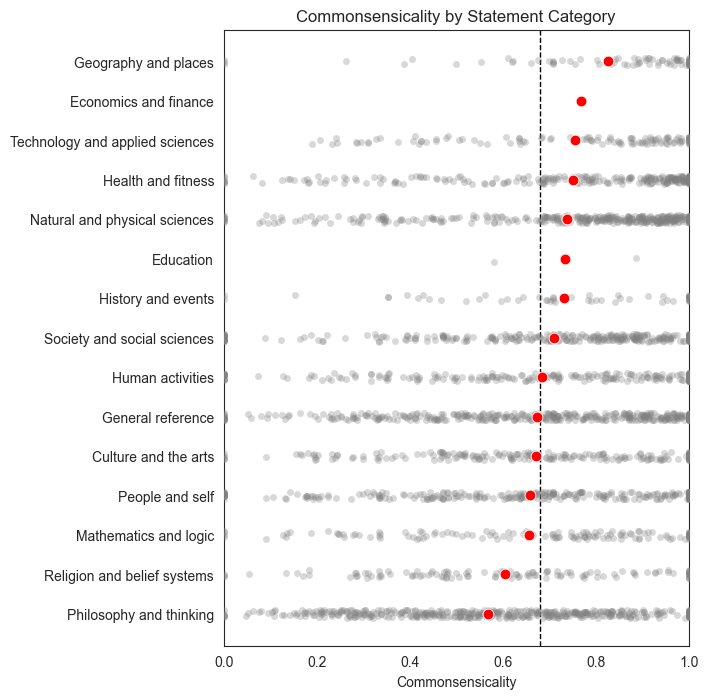

In [82]:
plot_df_pd = category_plot_df.to_pandas()

plt.figure(figsize=(6, 8))


ax = sns.stripplot(
    data=plot_df_pd,
    x="actual_commonsensicality",
    y="statementCategory",
    order=cat_order,
    alpha=0.3,
    color="gray",
    jitter=True,
)


mean_points_pd = cat_means_pd.rename(columns={"mean_commonsensicality": "x"})
sns.scatterplot(
    data=mean_points_pd,
    x="x",
    y="statementCategory",
    hue_order=cat_order,
    color="red",
    s=60,
    zorder=10,
    ax=ax,
)


overall_mean = plot_df_pd["actual_commonsensicality"].mean()

plt.axvline(x=overall_mean, color="black", linestyle="--", linewidth=1)

plt.xlim(0, 1)
plt.xlabel("Commonsensicality")
plt.ylabel("")
plt.title("Commonsensicality by Statement Category")
plt.show()

## Design point average commonsensicality

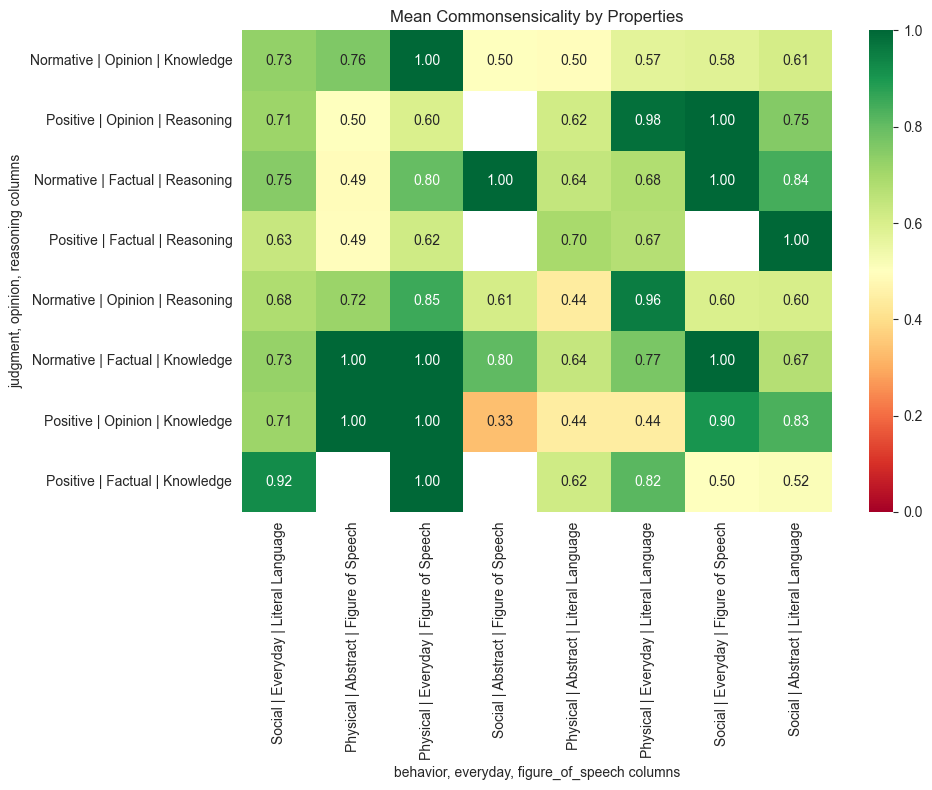

In [83]:
replace_dict = {
    "behavior": {"Physical": 0, "Social": 1},
    "everyday": {"Abstract": 0, "Everyday": 1},
    "figure_of_speech": {"Literal Language": 0, "Figure of Speech": 1},
    "judgment": {"Positive": 0, "Normative": 1},
    "opinion": {"Factual": 0, "Opinion": 1},
    "reasoning": {"Knowledge": 0, "Reasoning": 1},
}
inv_replace_dict = {
    col: {v: k for k, v in mapping.items()} for col, mapping in replace_dict.items()
}


df_replaced = statement_commonsensicality_with_properties

for col in inv_replace_dict.keys():
    df_replaced = df_replaced.with_columns(
        pl.col(col)
        .map_elements(
            lambda x: inv_replace_dict[col].get(x, f"Unmapped_{x}"),
            return_dtype=pl.String,
        )
        .alias(col)
    )

df_with_labels = df_replaced.with_columns(
    [
        pl.format(
            "{} | {} | {}",
            pl.col("behavior"),
            pl.col("everyday"),
            pl.col("figure_of_speech"),
        ).alias("x_label"),
        pl.format(
            "{} | {} | {}", pl.col("judgment"), pl.col("opinion"), pl.col("reasoning")
        ).alias("y_label"),
    ]
)

df_heat = (
    df_with_labels.group_by(["x_label", "y_label"])
    .agg([pl.col("actual_commonsensicality").mean().alias("avg_commonsensicality")])
    .pivot(
        index="y_label",
        on="x_label",
        values="avg_commonsensicality",
    )
)

df_heat_pd = df_heat.to_pandas()


df_heat_pd = df_heat_pd.set_index("y_label")

plt.figure(figsize=(10, 8))

sns.heatmap(
    df_heat_pd,
    cmap="RdYlGn",
    vmin=0,
    vmax=1,
    annot=True,
    fmt=".2f",
)

plt.title("Mean Commonsensicality by Properties")
plt.xlabel("behavior, everyday, figure_of_speech columns")
plt.ylabel("judgment, opinion, reasoning columns")
plt.tight_layout()
plt.show()

In [88]:
df_inidivial_pivoted = df_indiviudal.pivot(
    index="userSessionId",
    on="informationType",
    values="experimentInfo",
    aggregate_function="first"
)

df_inidivial_pivoted

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational
str,str,str,str,str
"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""ZT_ckkMnCIWKaeFQtEjEdiIpFjx2xk…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""VPgzPGNjKA4_OQ5VJvvEKyeoAe2DpZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""wx2DpRTkgySjtK2a8sgKVRHV_hi-F7…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
…,…,…,…,…
"""KpubsqOHnHXdBEqylN2__po-U0wHlf…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…"
"""UEfxq7uNPbKidHGzZg_-F8a5WgMqFP…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…"
"""cvy7xTWzVRKzMe6hlg5hbd6OCmDm0g…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…"


In [93]:
df_inidivial_pivoted.filter(
    pl.col("demographics").is_not_null()
    & pl.col("demographicsLongInternational").is_null()
)

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational
str,str,str,str,str
"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""ZT_ckkMnCIWKaeFQtEjEdiIpFjx2xk…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""VPgzPGNjKA4_OQ5VJvvEKyeoAe2DpZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""wx2DpRTkgySjtK2a8sgKVRHV_hi-F7…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
…,…,…,…,…
"""iyE8Q-Hq54GCMtOYlzBvUHfEAq_Oyr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""NvsQs6nVeQJQ42gDnTQnuWiJUVoRPs…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""COQN5Y4-ppLuwdccoKWRqPFs6de7Yr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null


In [94]:
df_inidivial_pivoted.filter(
    pl.col("demographics").is_null()
    & pl.col("demographicsLongInternational").is_not_null()
)

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational
str,str,str,str,str
"""yUfJswvhfTgY5NDQfXpx7q_Vy7iPXX…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…"
"""ZvL0KmZG99yXp5MAewAapBRK7Y6PoY…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…"
"""Qt2_Z0v0DTTt6XZ9eMEAWWPRPTrZQb…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…"
"""CranewGsPv_jk5SinY_dHzLCVFxYkY…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…"
"""LpybvN9troXTId5wYSOiZygOp95h_G…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…"
…,…,…,…,…
"""KpubsqOHnHXdBEqylN2__po-U0wHlf…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…"
"""UEfxq7uNPbKidHGzZg_-F8a5WgMqFP…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…"
"""cvy7xTWzVRKzMe6hlg5hbd6OCmDm0g…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…"


## Commonsensicality by country

A figure that shows the statement commonsensicality by dimension for top countries where the users are from.

In [109]:
import ast

df_filtered = df_inidivial_pivoted.filter(
    pl.col("demographics").is_not_null()
    & pl.col("demographicsLongInternational").is_null()
)


df_with_crt = df_filtered.with_columns(
    [
        pl.col("CRT")
        .map_elements(
            lambda x: ast.literal_eval(x)["result"]["score"] if x is not None else None
        )
        .alias("crt_score"),
        pl.col("rmeTen")
        .map_elements(
            lambda x: ast.literal_eval(x)["result"]["score"] if x is not None else None
        )
        .alias("rmeTen_score"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("birth_year")
                if x is not None
                else None
            )
        )
        .alias("birth_year"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("gender")
                if x is not None
                else None
            )
        )
        .alias("gender"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("marital_status")
                if x is not None
                else None
            )
        )
        .alias("marital_status"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("language_primary")
                if x is not None
                else None
            )
        )
        .alias("language_primary"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("english_written")
                if x is not None
                else None
            )
        )
        .alias("english_written"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("english_spoken")
                if x is not None
                else None
            )
        )
        .alias("english_spoken"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("employment_status")
                if x is not None
                else None
            )
        )
        .alias("employment_status"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("country_reside")
                if x is not None
                else None
            )
        )
        .alias("country_reside"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("education_US")
                if x is not None
                else None
            )
        )
        .alias("education_US"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("latin_US")
                if x is not None
                else None
            )
        )
        .alias("latin_US"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("race_US")
                if x is not None
                else None
            )
        )
        .alias("race_US"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("income_US")
                if x is not None
                else None
            )
        )
        .alias("income_US"),
    ]
)

df_with_crt

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US
str,str,str,str,str,i64,i64,str,str,str,str,i64,i64,str,str,str,str,list[str],str
"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0,4,"""1999""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""7""","""No""","[""White""]","""$100,000-$149,999"""
"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0,4,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null
"""ZT_ckkMnCIWKaeFQtEjEdiIpFjx2xk…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0,3,"""1985""","""male""","""Married or Domestic Partnershi…","""Korean""",5,5,"""Out of work and looking for wo…","""United States""","""4""","""Yes""","[""Asian"", ""White""]","""$30,000-$39,999"""
"""VPgzPGNjKA4_OQ5VJvvEKyeoAe2DpZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0,4,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null
"""wx2DpRTkgySjtK2a8sgKVRHV_hi-F7…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0,8,"""1961""","""female""","""Divorced""","""English""",5,5,"""Employed for wages""","""United States""","""5""","""No""","[""White""]","""$50,000-$74,999"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""iyE8Q-Hq54GCMtOYlzBvUHfEAq_Oyr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,4,8,"""1982""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""8""","""No""","[""White""]","""$100,000-$149,999"""
"""NvsQs6nVeQJQ42gDnTQnuWiJUVoRPs…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0,7,"""1960""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""4""","""No""","[""White""]","""$75,000-$99,999"""
"""COQN5Y4-ppLuwdccoKWRqPFs6de7Yr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,4,8,"""1957""","""female""","""Single Never Married""","""English""",5,5,"""Retired""","""United States""","""6""",null,"[""White""]","""$20,000-$29,999"""


In [110]:
df_with_crt

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US
str,str,str,str,str,i64,i64,str,str,str,str,i64,i64,str,str,str,str,list[str],str
"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0,4,"""1999""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""7""","""No""","[""White""]","""$100,000-$149,999"""
"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0,4,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null
"""ZT_ckkMnCIWKaeFQtEjEdiIpFjx2xk…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0,3,"""1985""","""male""","""Married or Domestic Partnershi…","""Korean""",5,5,"""Out of work and looking for wo…","""United States""","""4""","""Yes""","[""Asian"", ""White""]","""$30,000-$39,999"""
"""VPgzPGNjKA4_OQ5VJvvEKyeoAe2DpZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0,4,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null
"""wx2DpRTkgySjtK2a8sgKVRHV_hi-F7…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0,8,"""1961""","""female""","""Divorced""","""English""",5,5,"""Employed for wages""","""United States""","""5""","""No""","[""White""]","""$50,000-$74,999"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""iyE8Q-Hq54GCMtOYlzBvUHfEAq_Oyr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,4,8,"""1982""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""8""","""No""","[""White""]","""$100,000-$149,999"""
"""NvsQs6nVeQJQ42gDnTQnuWiJUVoRPs…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0,7,"""1960""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""4""","""No""","[""White""]","""$75,000-$99,999"""
"""COQN5Y4-ppLuwdccoKWRqPFs6de7Yr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,4,8,"""1957""","""female""","""Single Never Married""","""English""",5,5,"""Retired""","""United States""","""6""",null,"[""White""]","""$20,000-$29,999"""


In [114]:
df_commonsense_country_info = df_with_crt.join(df_session, left_on="userSessionId", right_on="sessionId", how="inner")

In [120]:
df_country_plot = df_commonsense_country_info.group_by("country_reside").agg(
    pl.col("commonsensicality").mean().alias("avg_commonsensicality")
)

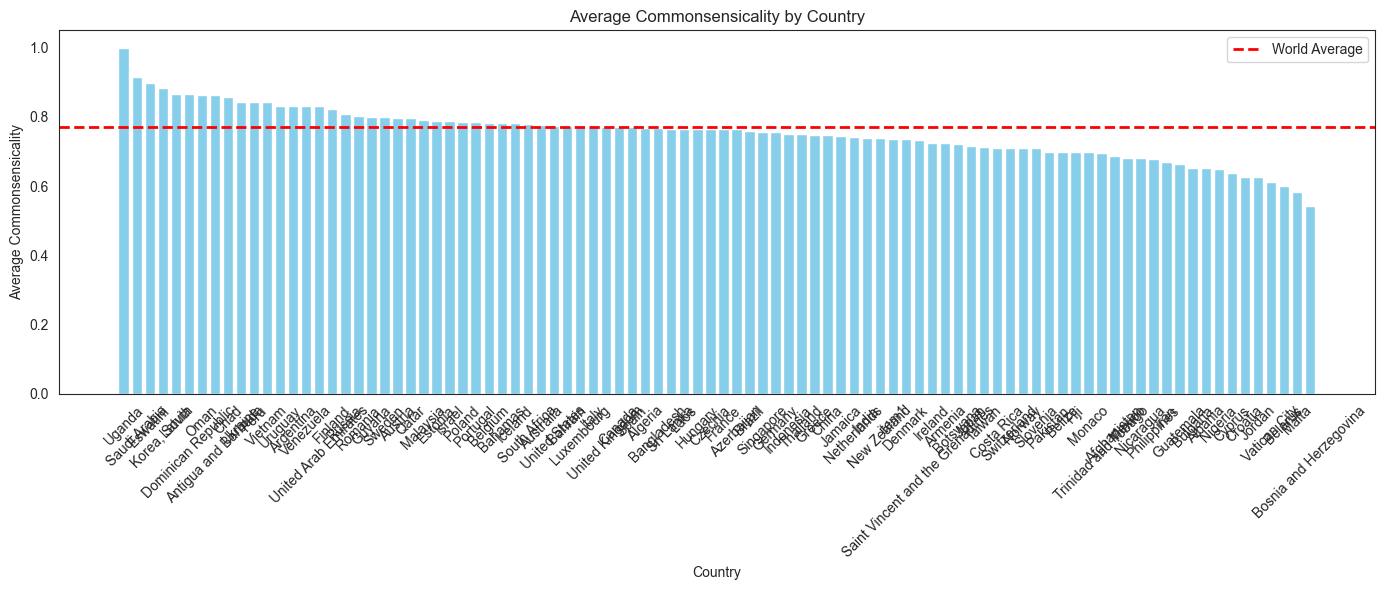

In [131]:


df_plot = df_country_plot.to_pandas()


df_plot = df_plot.sort_values("avg_commonsensicality", ascending=False)


world_avg = df_commonsense_country_info["commonsensicality"].mean()

# Plot the sorted bar chart
plt.figure(figsize=(14, 6))
plt.bar(df_plot["country_reside"], df_plot["avg_commonsensicality"], color="skyblue")
plt.xlabel("Country")
plt.ylabel("Average Commonsensicality")
plt.title("Average Commonsensicality by Country")
plt.xticks(rotation=45)


plt.axhline(y=world_avg, color="red", linestyle="--", linewidth=2, label="World Average")

plt.legend()
plt.tight_layout()
plt.show()